# Preprocessing the data and training a simple LSTM model

* Import libraries and load data
* Put data into the correct format an LSTM
    * Target: count (number of departures/bike checkouts)
    * Time steps: hourly
    * Features: everything else        
* Start with LSTM with one layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = 'data/processed/divvy_data_cleaned.pkl'
df = pd.read_pickle(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11272007 entries, 0 to 11272758
Data columns (total 25 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             string         
 1   rideable_type       string         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  string         
 5   end_station_name    string         
 6   start_lat           Float64        
 7   start_lng           Float64        
 8   end_lat             Float64        
 9   end_lng             Float64        
 10  member_casual       string         
 11  start_id            string         
 12  end_id              string         
 13  start_hour          datetime64[ns] 
 14  start_day           datetime64[ns] 
 15  start_month         int32          
 16  start_year          int32          
 17  start_dayofweek     int32          
 18  start_holiday       int64          
 19  SNOW                stri

In [3]:
#may add more dummy variables for features later

In [4]:
df_preprocessed = df[['start_id', 'start_hour', 'start_day', 'start_month', 'start_year', 'start_dayofweek', 'start_holiday', 'SNOW', 'TMAX', 'TMIN', 'PRCP', 'SNWD']]

In [5]:
df_preprocessed.head()

,start_id,start_hour,start_day,start_month,start_year,start_dayofweek,start_holiday,SNOW,TMAX,TMIN,PRCP,SNWD
0,<NA>,2024-01-01,2024-01-01,1,2024,0,0,0,11,-17,0,0
1,<NA>,2024-01-01,2024-01-01,1,2024,0,0,0,11,-17,0,0
2,<NA>,2024-01-01,2024-01-01,1,2024,0,0,0,11,-17,0,0
3,"['TA1305000032', 'CHI00233']",2024-01-01,2024-01-01,1,2024,0,0,0,11,-17,0,0
4,"['13430', 'CHI00358']",2024-01-01,2024-01-01,1,2024,0,0,0,11,-17,0,0


In [6]:
df_preprocessed.isnull().sum()

start_id           2231283
start_hour               0
start_day                0
start_month              0
start_year               0
start_dayofweek          0
start_holiday            0
SNOW                     0
TMAX                  1024
TMIN                 25636
PRCP                 81082
SNWD                 16295
dtype: int64

In [7]:
df_cleaned = df_preprocessed.dropna()

In [8]:
df_cleaned.isnull().sum()

start_id           0
start_hour         0
start_day          0
start_month        0
start_year         0
start_dayofweek    0
start_holiday      0
SNOW               0
TMAX               0
TMIN               0
PRCP               0
SNWD               0
dtype: int64

In [9]:
df_cleaned['start_id'].unique().value_counts().sum()

2012

In [10]:
df_test = df_cleaned.groupby('start_hour')['start_id'].agg('count')                                                           
df_test

start_hour
2024-01-01 00:00:00    137
2024-01-01 01:00:00    296
2024-01-01 02:00:00    198
2024-01-01 03:00:00     36
2024-01-01 04:00:00     16
                      ... 
2025-11-28 19:00:00    174
2025-11-28 20:00:00     99
2025-11-28 21:00:00    129
2025-11-28 22:00:00     84
2025-11-28 23:00:00     87
Name: start_id, Length: 16530, dtype: int64

In [11]:
df_aggregated = df_cleaned.groupby('start_hour').agg(
    {
        'start_id': 'count',
        'start_day': 'min',
        'start_month': 'min',
        'start_year': 'min',
        'start_dayofweek': 'min',
        'start_holiday': 'min',
        'SNOW': 'min',
        'TMAX': 'min',
        'TMIN': 'min',
        'PRCP': 'min',
        'SNWD': 'min',
    }
)

df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16530 entries, 2024-01-01 00:00:00 to 2025-11-28 23:00:00
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_id         16530 non-null  int64         
 1   start_day        16530 non-null  datetime64[ns]
 2   start_month      16530 non-null  int32         
 3   start_year       16530 non-null  int32         
 4   start_dayofweek  16530 non-null  int32         
 5   start_holiday    16530 non-null  int64         
 6   SNOW             16530 non-null  string        
 7   TMAX             16530 non-null  string        
 8   TMIN             16530 non-null  string        
 9   PRCP             16530 non-null  string        
 10  SNWD             16530 non-null  string        
dtypes: datetime64[ns](1), int32(3), int64(2), string(5)
memory usage: 1.3 MB


In [12]:
data = df_aggregated.rename(columns={'start_id': 'count', 'start_day': 'day', 'start_month': 'month', 'start_year': 'year', 'start_dayofweek': 'dayof week', 'start_holiday': 'holiday'})
data.head()

,count,day,month,year,dayof week,holiday,SNOW,TMAX,TMIN,PRCP,SNWD
start_hour,,,,,,,,,,,
2024-01-01 00:00:00,137,2024-01-01,1,2024,0,0,0,11,-17,0,0
2024-01-01 01:00:00,296,2024-01-01,1,2024,0,0,0,11,-17,0,0
2024-01-01 02:00:00,198,2024-01-01,1,2024,0,0,0,11,-17,0,0
2024-01-01 03:00:00,36,2024-01-01,1,2024,0,0,0,11,-17,0,0
2024-01-01 04:00:00,16,2024-01-01,1,2024,0,0,0,11,-17,0,0


In [13]:
file_path = 'data/processed/data_for_models.pkl'
data.to_pickle(file_path)
print(f"\nDataFrame successfully saved to {file_path}")


DataFrame successfully saved to data/processed/data_for_models.pkl


In [14]:
target = data['count'].values.astype(float)  #using number of departures as target

In [15]:
target

array([137., 296., 198., ..., 129.,  84.,  87.])

In [16]:
target.shape

(16530,)

In [17]:
#normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1)) #minmax scaler does not assume the data has a specific distribution shape
target_normalized = scaler.fit_transform(target.reshape(-1, 1))

In [18]:
len(target) - 12
#0 to 16517

#for in 0,...,16517

16518

In [19]:
"""
first x: indices 0 to 11
first y: index 12

second x: indices 1 to 12
second y: index 13
.
.
.

16517'th x: indices 16517 to 16529
16517'th y: index 16529
"""

"\nfirst x: indices 0 to 11\nfirst y: index 12\n\nsecond x: indices 1 to 12\nsecond y: index 13\n.\n.\n.\n\n16517'th x: indices 16517 to 16529\n16517'th y: index 16529\n"

In [20]:
#create sequences
def create_sequences(target, seq_length):
    xs = []
    ys = []
    for i in range(len(target) - seq_length):
        x = target[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  #trying sequence length of 12 hours
X, y = create_sequences(target_normalized, seq_length)


In [21]:
#indices = seq_length to len(target)

In [22]:
indices = data.index[12:]

In [23]:
#perform train/test split (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
#convert to pytorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [25]:
len(y_test)

4956

In [26]:
indices_test = indices[train_size:]

In [27]:
indices_test

DatetimeIndex(['2025-04-27 12:00:00', '2025-04-27 13:00:00',
               '2025-04-27 14:00:00', '2025-04-27 15:00:00',
               '2025-04-27 16:00:00', '2025-04-27 17:00:00',
               '2025-04-27 18:00:00', '2025-04-27 19:00:00',
               '2025-04-27 20:00:00', '2025-04-27 21:00:00',
               ...
               '2025-11-28 14:00:00', '2025-11-28 15:00:00',
               '2025-11-28 16:00:00', '2025-11-28 17:00:00',
               '2025-11-28 18:00:00', '2025-11-28 19:00:00',
               '2025-11-28 20:00:00', '2025-11-28 21:00:00',
               '2025-11-28 22:00:00', '2025-11-28 23:00:00'],
              dtype='datetime64[ns]', name='start_hour', length=4956, freq=None)

In [28]:
X_test.shape

torch.Size([4956, 12, 1])

In [29]:
#X_train

In [30]:
#make a custom dataset for a DataLoader
class BikeshareDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [31]:
train_dataset = BikeshareDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [32]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        #LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        #take the last timestep's output and pass to fully connected layer
        out = self.fc(out[:, -1, :])
        return out

Mean Squared Error (MSE) for the loss function, and Adam (adaptive moment estimation) optimizer is supposed to be efficient for LSTMs.

In [33]:
#instantiate model, loss, optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.004491
Epoch [20/100], Loss: 0.008360
Epoch [30/100], Loss: 0.003288
Epoch [40/100], Loss: 0.002957
Epoch [50/100], Loss: 0.002128
Epoch [60/100], Loss: 0.001106
Epoch [70/100], Loss: 0.011349
Epoch [80/100], Loss: 0.000769
Epoch [90/100], Loss: 0.004419
Epoch [100/100], Loss: 0.001119


In [34]:
#evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f'Test Loss: {test_loss.item():.6f}')

Test Loss: 0.004701


In [35]:
y_pred_test.shape

torch.Size([4956, 1])

In [36]:
#inverse transform to get predicted values from test
y_pred_test = scaler.inverse_transform(y_pred_test.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

In [37]:
y_pred_test

array([[1035.2316  ],
       [1207.9034  ],
       [1191.4199  ],
       ...,
       [  40.965687],
       [ 103.281975],
       [  38.73686 ]], dtype=float32)

In [38]:
ground_truth_df = pd.DataFrame(y_test[0:199], index=indices_test[0:199])
prediction_df = pd.DataFrame(y_pred_test[0:199], index=indices_test[0:199])

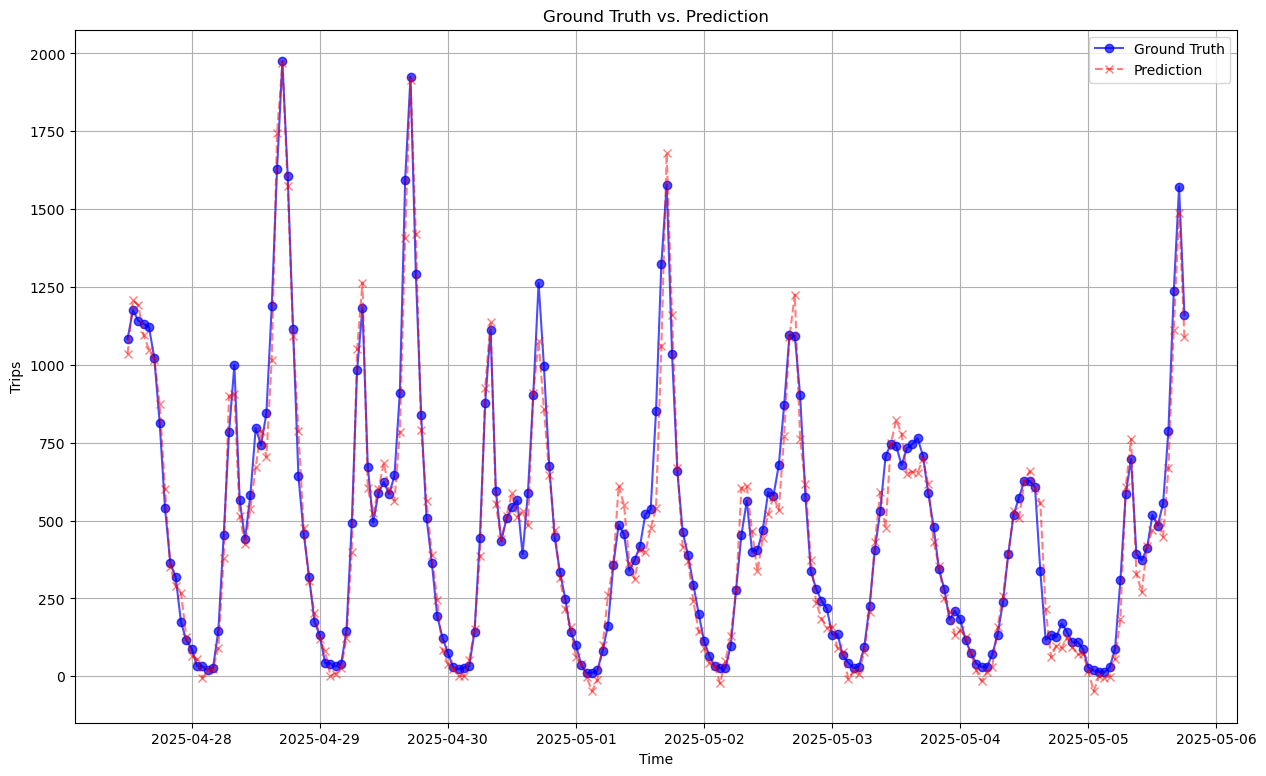

In [43]:
# Plotting
plt.figure(figsize=(15, 9))
plt.plot(ground_truth_df, label='Ground Truth', color='blue', marker='o', alpha=0.7)
plt.plot(prediction_df, label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Trips')
plt.title('Ground Truth vs. Prediction')
plt.legend()
plt.grid(True)
plt.show()

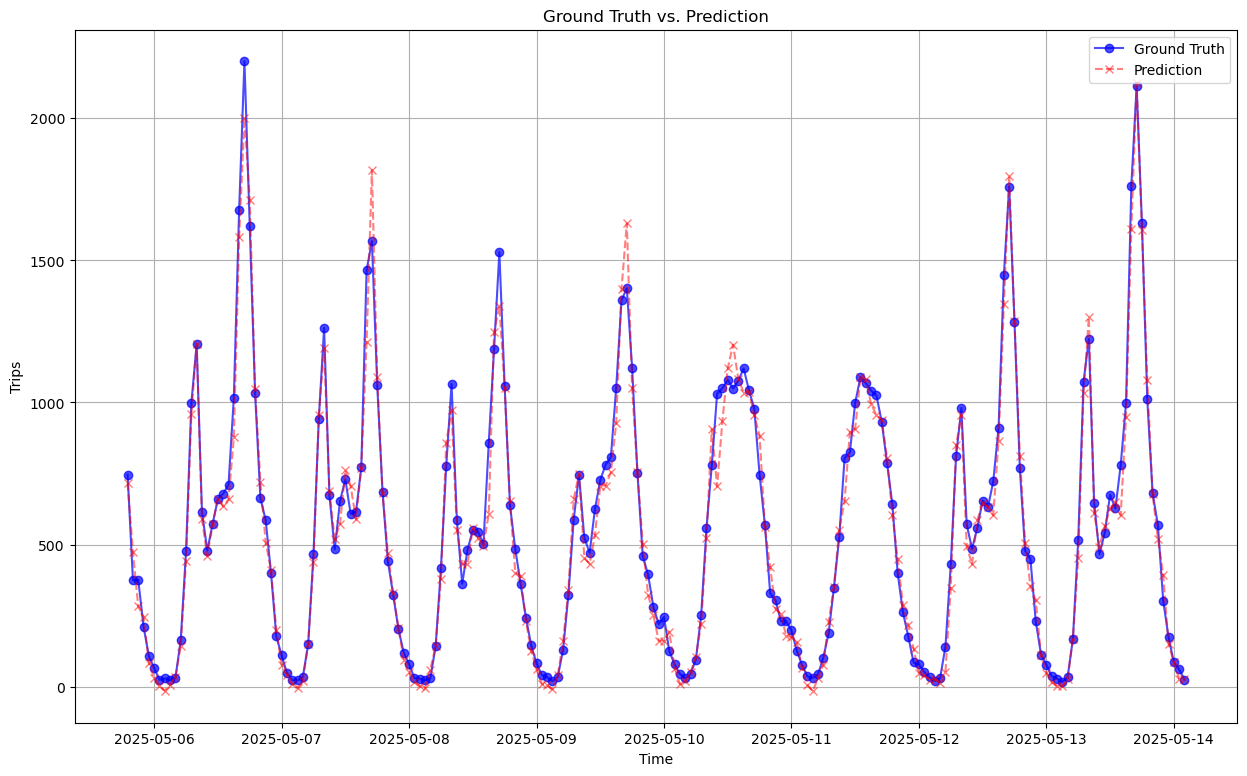

In [44]:
ground_truth_df_2 = pd.DataFrame(y_test[199:399], index=indices_test[199:399])
prediction_df_2 = pd.DataFrame(y_pred_test[199:399], index=indices_test[199:399])

# Plotting
plt.figure(figsize=(15, 9))
#ground_truth_df.plot(label='Ground Truth', color='blue', marker='o', alpha=0.7)
#prediction_df.plot(label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)
plt.plot(ground_truth_df_2, label='Ground Truth', color='blue', marker='o', alpha=0.7)
plt.plot(prediction_df_2, label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Trips')
plt.title('Ground Truth vs. Prediction')
plt.legend()
plt.grid(True)
plt.show()